# Сборный проект 1

Вы работаете в интернет-магазине «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Вам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

Перед вами данные до 2016 года. Представим, что сейчас декабрь 2016 г., и вы планируете кампанию на 2017-й. Нужно отработать принцип работы с данными. Не важно, прогнозируете ли вы продажи на 2017 год по данным 2016-го или же 2027-й — по данным 2026 года.

В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».

Описание данных:

- Name — название игры
- Platform — платформа
- Year_of_Release — год выпуска
- Genre — жанр игры
- NA_sales — продажи в Северной Америке (миллионы долларов)
- EU_sales — продажи в Европе (миллионы долларов)
- JP_sales — продажи в Японии (миллионы долларов)
- Other_sales — продажи в других странах (миллионы долларов)
- Critic_Score — оценка критиков (максимум 100)
- User_Score — оценка пользователей (максимум 10)
- Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

## Шаг 1. Откройте файл с данными и изучите общую информацию

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st

df = pd.read_csv('games.csv')

df.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Отобразим информацию о пропусках более наглядно

In [3]:
#Подсчет количества пропусков в каждом столбцу
null_counts = df.isnull().sum()
#Пропуски в каждом столбце в процентах
null_pct = null_counts / df.shape[0] * 100

#Объединим все в один датафрейм
null_df = pd.DataFrame({'Количество пропусков':null_counts,'В процентах':null_pct})
null_df = null_df.T.astype(int)
null_df

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
Количество пропусков,2,0,269,2,0,0,0,0,8578,6701,6766
В процентах,0,0,1,0,0,0,0,0,51,40,40


Большая часть пропусков приходится на последние 3 столбца. В "critic_score" половина значений - пропуски. В "user_score" и "rating", чуть меньше, но все равно много. Есть 2 пропуска в столбцах "name" и "genre". Также немного в "year_of_release".

Пропуски в столбце "critic_score", скорей всего связаны с тем, что не на все игры критики оставляют отзывы. Возможно до определенного года этого вообще не делали.

Также вероятно, что не для всех игр был известен год выпуска, отсюда и пропуски.

Столбцы с малым количеством пропусков можно оправдать человеческим фактором.

Пропуски в столбце "Rating" в процентном соотношении практически равны пропускам в "User_score", возможно произошла какая-то ошибка выгрузки данных, которая затронула оба этих столбца.

In [4]:
df[(df['User_Score'].isnull()) & (df['Rating'].isnull())].shape[0]

6630

Большая часть пропусков присутствует в последних трех столбцах: "Critic_score", "User_score" и "Rating". Причем в последних двух пропуски идут практически попарно. 

Отсутствие значение в вышеупомянутых столбцах можно объяснить самим отсутствием данных о рейтингах и отзывах некоторых игр, ошибками в выгрузке данных или человеческим фактором.

## Шаг 2. Подготовьте данные

Заменим названия столбцов (приведем к нижнему регистру);

In [8]:
df.columns = df.columns.str.lower()
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


Займемся пропусками и преобразованием типов, где необходимо.

In [9]:
df['year_of_release'].fillna(-1,inplace=True)
game_years = df.pivot_table(index='name',values='year_of_release',aggfunc='first').to_dict()['year_of_release']

def mapper(row):
    if row['year_of_release'] == -1:
        return game_years[row['name']]
    return row['year_of_release']


df['year_of_release'] = df.apply(mapper,axis=1)
#Сразу преобразуем к целочисленному типу данных
df['year_of_release'] = df['year_of_release'].astype(int)

# Избавимся от пары строчек, где пропуски в столбцах имя и жанр
# df = df.dropna().reset_index(drop=True)

#Проверка
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16715 non-null  int32  
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: float64(5), int32(1), object(5)
memory usage: 1.3+ MB


Поскольку в дальнейшем мы будем проводить статистический тест, то заменять пропуски в столбцах с числовыми значениями на среднее или медиану нельзя. Поэтому оставим столбцы "user_score", "critic_score" и "rating" без изменений.

Пропуски в столбце "year_of_release" заменили на значения, которые для той же игры присутствуют на других платформах. Так получилось заполнить не все пропуски, поэтому остальные оставим значением -1.

Посчитаем суммарные продажи во всех регионах и запишем их в отдельный столбец

In [10]:
df['sum_sales'] = df[['na_sales','eu_sales','jp_sales']].sum(axis=1)
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sum_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8,E,74.09
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,39.47
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,32.23
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8,E,29.82
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,30.38


В данном разделе мы преобразовали имена столбцов к нужному формату, обработали пропуски, где это возможно и произвели преобразоание типов там, где это было необходимо. Также добавили новый столбец, который хранит в себе суммарные продажи каждой игры по всем регионам.

## Шаг 3. Проведите исследовательский анализ данных

Посмотрим, сколько игр выпускалось в разные годы. Определим важны ли данные за все периоды?

In [75]:
df['year_of_release'].value_counts().sort_index(ascending=False)

 2016     502
 2015     606
 2014     581
 2013     548
 2012     655
 2011    1148
 2010    1263
 2009    1429
 2008    1440
 2007    1201
 2006    1013
 2005     942
 2004     764
 2003     779
 2002     837
 2001     486
 2000     351
 1999     339
 1998     380
 1997     289
 1996     263
 1995     219
 1994     121
 1993      60
 1992      43
 1991      42
 1990      16
 1989      17
 1988      15
 1987      16
 1986      21
 1985      14
 1984      14
 1983      17
 1982      36
 1981      46
 1980       9
-1        191
Name: year_of_release, dtype: int64

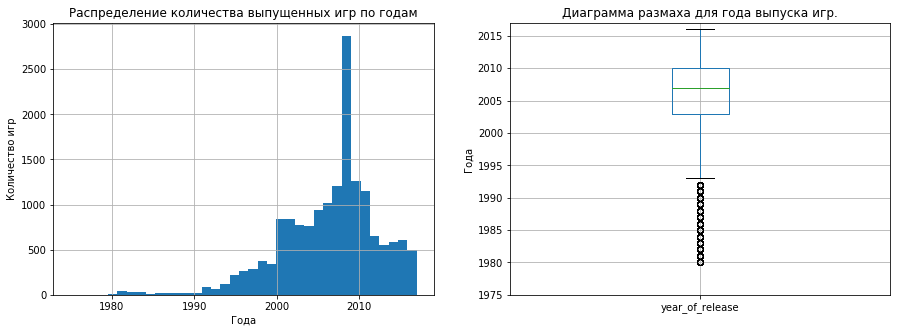

In [12]:
plt.rcParams['figure.figsize'] = (15,5)

plt.subplot(121)
df['year_of_release'].hist(bins=37,range=(1975,2017))
plt.title('Распределение количества выпущенных игр по годам')
plt.ylabel('Количество игр')
plt.xlabel('Года')

plt.subplot(122)
df['year_of_release'].to_frame().boxplot()
plt.ylim(1975,2017)
plt.title('Диаграмма размаха для года выпуска игр.')
plt.ylabel('Года')

plt.show()

Можно отбросить все данные до 1995 года

Посмотрим, как менялись продажи по платформам. Выберим платформы с наибольшими суммарными продажами и построим распределение по годам. За какой характерный срок появляются новые и исчезают старые платформы?

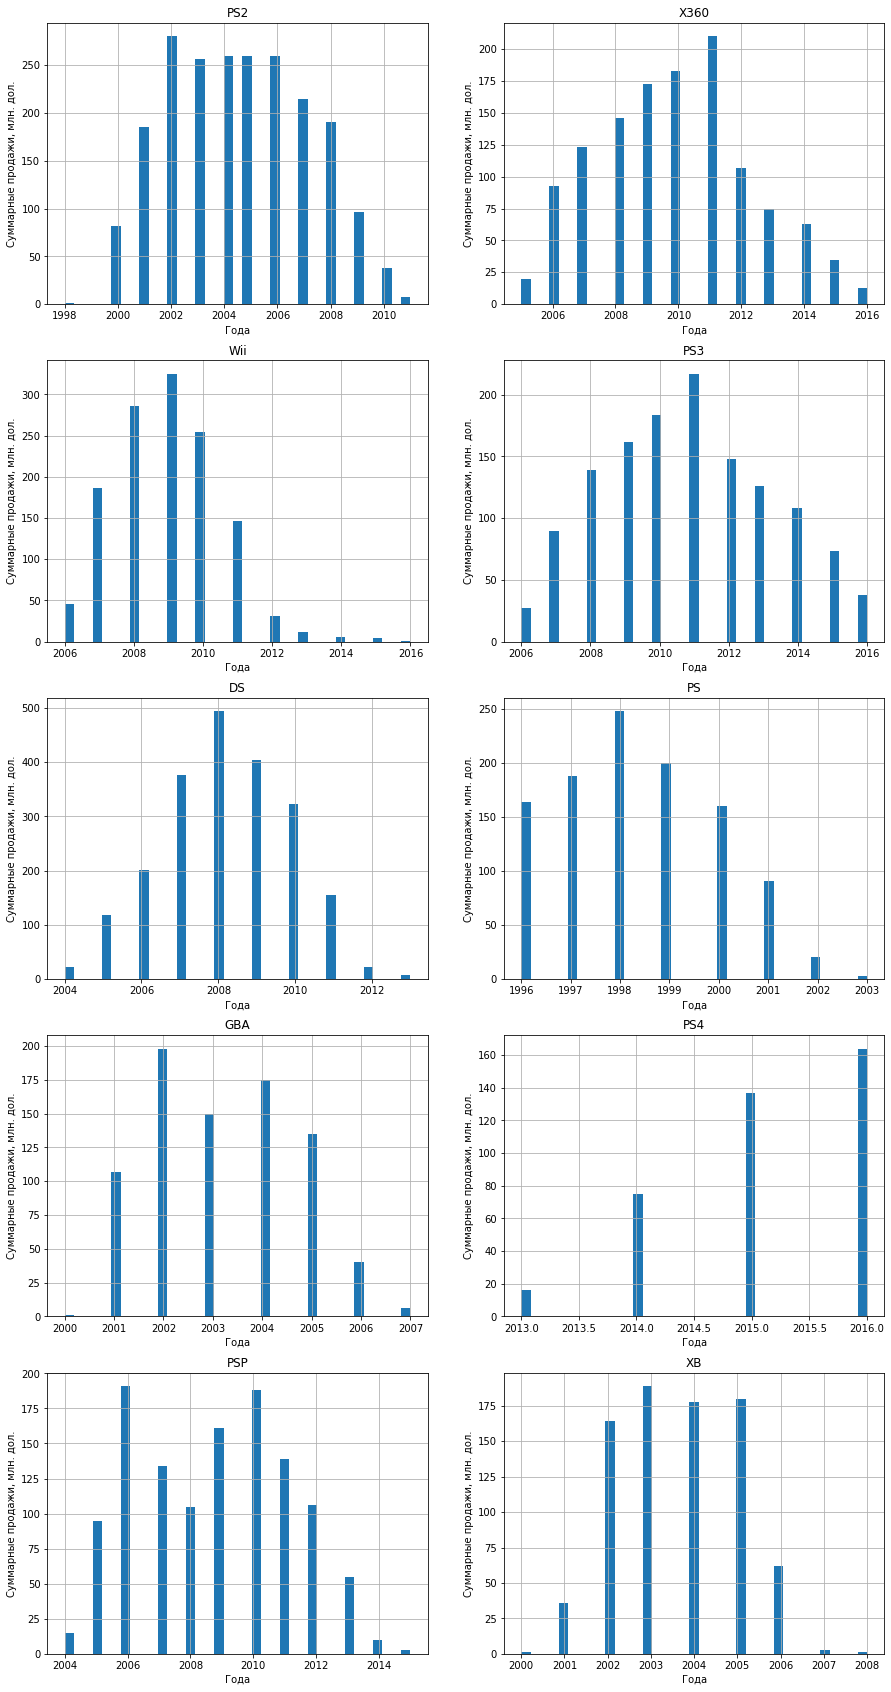

In [77]:
#Избавимся от игр, выпущенных до 1995 года
df = df.query('year_of_release > 1995')
#Извдечем топ-10 платформ
top_platforms = df.pivot_table(index='platform',values='sum_sales',aggfunc='sum'). \
                                                                    sort_values(by='sum_sales',ascending=False).head(10).index

#Распределение по годам для каждой рассматриваемой платформы
plt.rcParams['figure.figsize'] = (15,30)    

for i in range(len(top_platforms)):
    plt.subplot(5,2,i+1)
    platform = top_platforms[i]
    df.query('platform == @platform')['year_of_release'].hist(bins=37)
    plt.title(platform)
    plt.xlabel('Года')
    plt.ylabel('Суммарные продажи, млн. дол.')
    
plt.show()

Определим характерный срок существования платформы на примере PS. Самые ранние игры данной платформы выпускались в 1996 году, а к 2006 году количество игр резко упало. Дальше, в 2000 году, появилась PS2, игры к которой перестали выпускать к 2011 году. Затем, в 2006 году в игру вступает PS3, просуществовавшая до 2016 года и в завершает наш марафон PS4, которая к 2016 году находится на пике популярности.

По одному этому примеру характерным сроком существования платформы можно выделить 10 лет. За этот период платформа успевает расцвести и сгинуть. Другие платформы также далеко не ушли от этой цифры,у них 10 $\pm$1 год существования.

Изначально, нашей целью является прогноз популярности игр на 2017 год, потому надо выбрать данные за актуальный период. Скоре всего правильным тут будет взять данные с 2012 года (отняли половину характерного срока существования от 2017). Данная цифра была выбрана с той целью, чтобы не захватить платформы, которые окончательно покинут нас к 2017 году.

In [13]:
#Делаем срез
df = df.query('year_of_release > 2012').reset_index(drop=True)
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sum_sales
0,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97.0,8.2,M,17.09
1,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97.0,8.1,M,14.86
2,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,NaN,12.25
3,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,5.28,4.19,4.35,0.78,NaN,NaN,NaN,13.82
4,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97.0,8.3,M,10.65


Определим какие платформы лидируют по продажам, растут или падают? Выберите несколько потенциально прибыльных платформ.

In [14]:
#Извлечем имена платформ, лидирующие по средним продажам за актуальный период
potential_platforms = df.pivot_table(index='platform',values='sum_sales',aggfunc='sum')\
                                                                .sort_values(by='sum_sales',ascending=False).head().index
print('Потенциальные платформы для 2017 года:')
for platform in potential_platforms:
    print(platform)

Потенциальные платформы для 2017 года:
PS4
PS3
XOne
3DS
X360


Построим распределения для платформ, которые еще не построили.

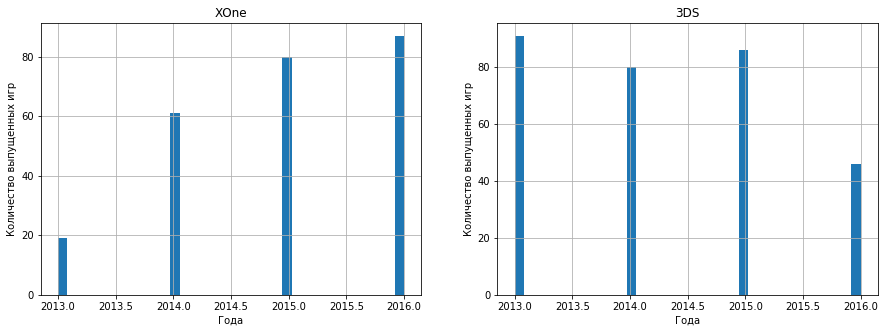

In [17]:
plt.rcParams['figure.figsize'] = (15,5) 

plt.subplot(1,2,1)
df.query('platform == "XOne"')['year_of_release'].hist(bins=37)
plt.title('XOne')
plt.xlabel('Года')
plt.ylabel('Количество выпущенных игр')

plt.subplot(1,2,2)
df.query('platform == "3DS"')['year_of_release'].hist(bins=37)
plt.title('3DS')
plt.xlabel('Года')
plt.ylabel('Количество выпущенных игр')

plt.show()

PS4 растет по продажам, как и XOne. PS3 падает, X360 тоже падает. 3DS начала падение.

Самыми важными платформами на 2017 год сразу можно выделить PS4 и XOne. Можно быть уверенным, то к 2017 году продажи по ним будут самыми выгодными.

Построим график «ящик с усами» по глобальным продажам каждой игры и разбивкой по платформам. Ответим на вопрос: велика ли разница в продажах? А в средних продажах на разных платформах?

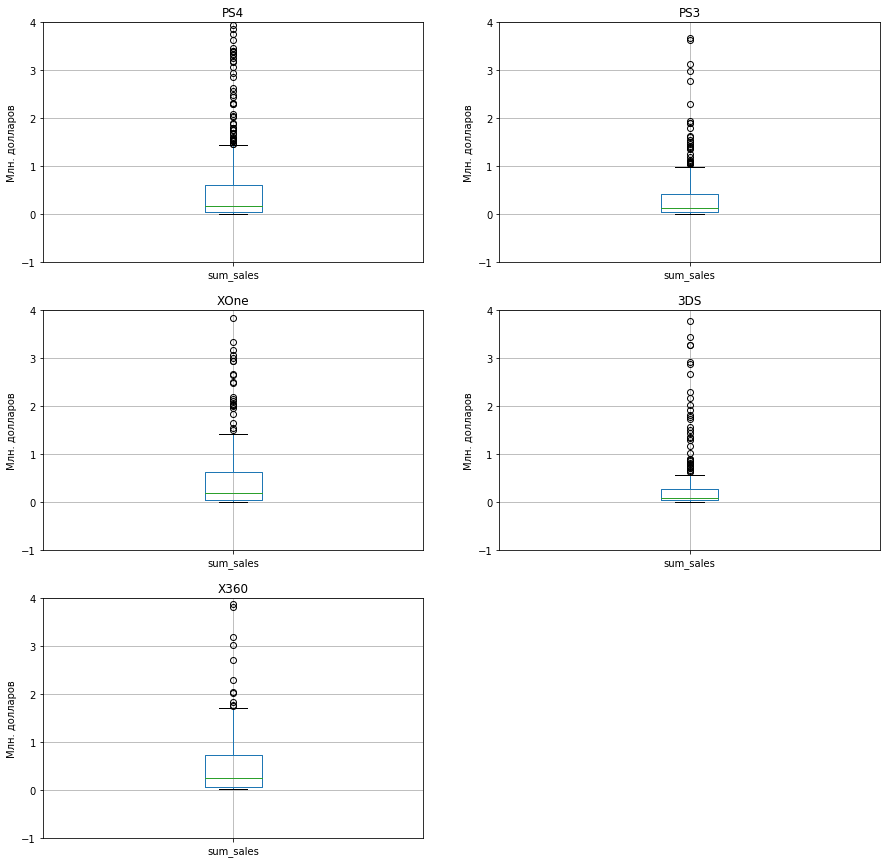

In [18]:
plt.rcParams['figure.figsize'] = (15,15) 

for i in range(len(potential_platforms)):
    plt.subplot(3,2,i+1)
    platform = potential_platforms[i]
    df.query('platform == @platform')[['platform','sum_sales']].boxplot()
    plt.title(platform)
    plt.ylabel('Млн. долларов')
    plt.ylim(-1,4)
    
plt.show()

По продажам на фоне других сильно выделяются следующие пдатформы: 
    1. PS4
    2. XOne
    3. X360 
    4. 3DS
    
Медиана, первый и второй квартиль для всех выбранных платформ выглядит примерно одинаково. Составление рейтинга было сделано по выбросам: на какой платформе продажи по играм чаще выходили за межквартильный размах.

In [20]:
#Подсчитаем среднее значенеи суммарных продаж по каждой платформе
PS4_mean = df.query('platform == "PS4"')['sum_sales'].mean()
XOne_mean = df.query('platform == "XOne"')['sum_sales'].mean()
X360_mean = df.query('platform == "X360"')['sum_sales'].mean()
PS3_mean = df.query('platform == "PS3"')['sum_sales'].mean()
_3DS_mean = df.query('platform == "3DS"')['sum_sales'].mean()

print('Среднее значение продаж на  PS4: {:.2f} млн. долларов'.format(PS4_mean))
print('Среднее значение продаж на XOne: {:.2f} млн. долларов'.format(XOne_mean))
print('Среднее значение продаж на X360: {:.2f} млн. долларов'.format(X360_mean))
print('Среднее значение продаж на PS3: {:.2f} млн. долларов'.format(PS3_mean))
print('Среднее значение продаж на  3DS: {:.2f} млн. долларов'.format(_3DS_mean))

Среднее значение продаж на  PS4: 0.68 млн. долларов
Среднее значение продаж на XOne: 0.59 млн. долларов
Среднее значение продаж на X360: 0.67 млн. долларов
Среднее значение продаж на PS3: 0.45 млн. долларов
Среднее значение продаж на  3DS: 0.45 млн. долларов


На первый взгляд кажется, что расчитанное значение для XOne должно быть больше, чем для X360. Ведь первое явно набирает популярность. Однако, данная разница обусловлена тем, что X360 прошла свой пик, а XOne еще нет.

Посмотрим, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Построим диаграмму рассеяния и посчитайте корреляцию между отзывами и продажами.

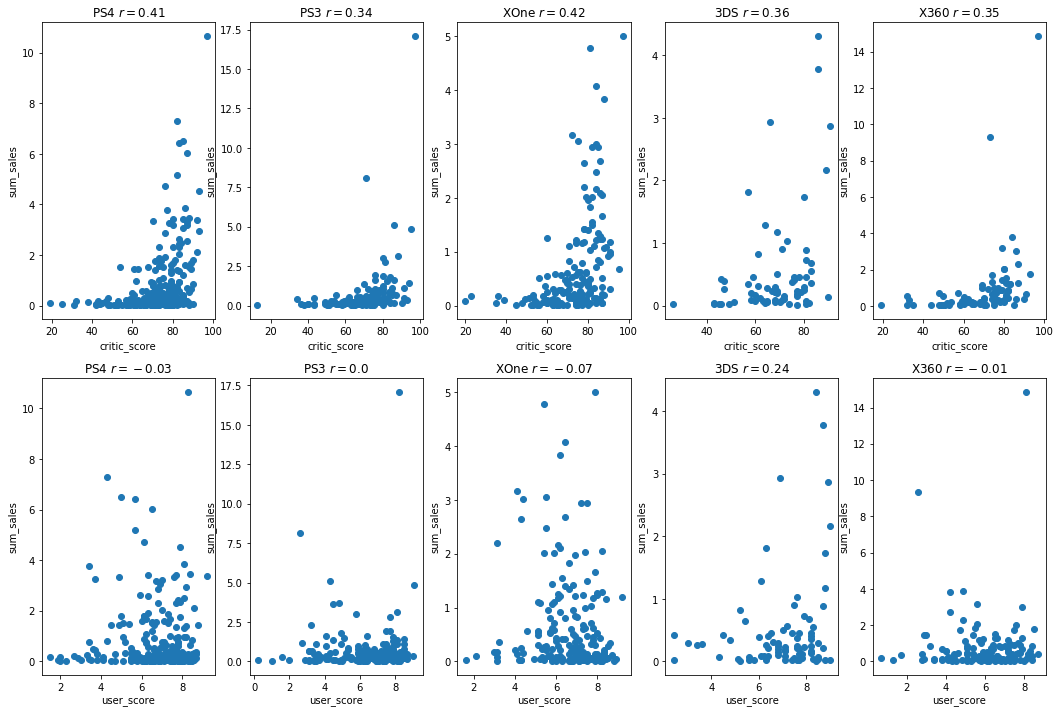

In [21]:
fig,ax = plt.subplots(2,5)

for i in range(5):
    platform = potential_platforms[i]
    df_critics = df.query('platform == @platform')[['critic_score','sum_sales']]
    df_users = df.query('platform == @platform and user_score != "tbd"')[['user_score','sum_sales']]
    df_users['user_score'] = pd.to_numeric(df_users['user_score'])
    c_critics = round(df_critics['critic_score'].corr(df_critics['sum_sales']),2)
    c_users = round(df_users['user_score'].corr(df_users['sum_sales']),2)
    ax[0,i].scatter(df_critics['critic_score'],df_critics['sum_sales'])
    ax[0,i].set_title(platform + ' $r = %s$' %c_critics)
    ax[0,i].set_ylabel('sum_sales')
    ax[0,i].set_xlabel('critic_score')
    ax[1,i].scatter(df_users['user_score'],df_users['sum_sales'])
    ax[1,i].set_title(platform + ' $r = %s$' %c_users)
    ax[1,i].set_ylabel('sum_sales')
    ax[1,i].set_xlabel('user_score')
    
fig.set_size_inches(18,12)
    
plt.show()

Для платформ PS4, XOne, X360, PS3 и 3DS отзывы критиков достаточно сильно влияют на суммарные продажи, коррелация здесь от 0.34 до 0.41.

Для этих же платформ влияние отзывов пользователей на продажи практически отсутствует, корреляция близка к нулю. С одним исключение - это платформа 3DS. Для нее характерно почти такое же сильное влияние отзывов пользователей на продажи как и в случае с отзывами критиков.

Можно сделать предварительный вывод, что для большинства популярных платформ наибольшее влияние на продажи оказывают отзывы критиков.

Посмотрим на общее распределение игр по жанрам. Что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами?

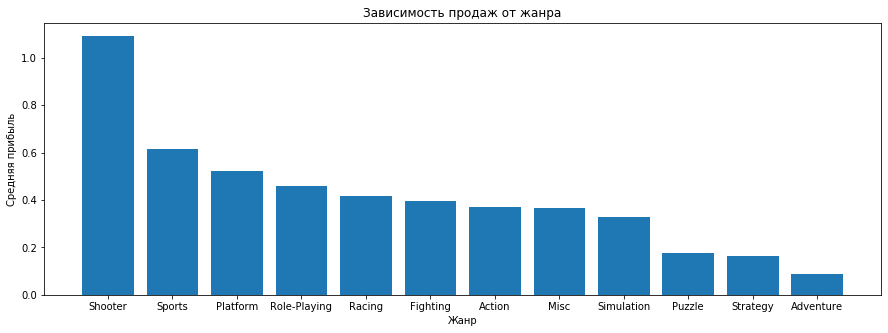

In [29]:
df_genre = df.pivot_table(index='genre',values='sum_sales').sort_values(by='sum_sales',ascending=False)
genres = df_genre.index
sales_per_genre = np.squeeze(df_genre.values)

plt.rcParams['figure.figsize'] = (15,5) 

plt.bar(genres,sales_per_genre)
plt.title('Зависимость продаж от жанра')
plt.xlabel('Жанр')
plt.ylabel('Средняя прибыль')

plt.show()

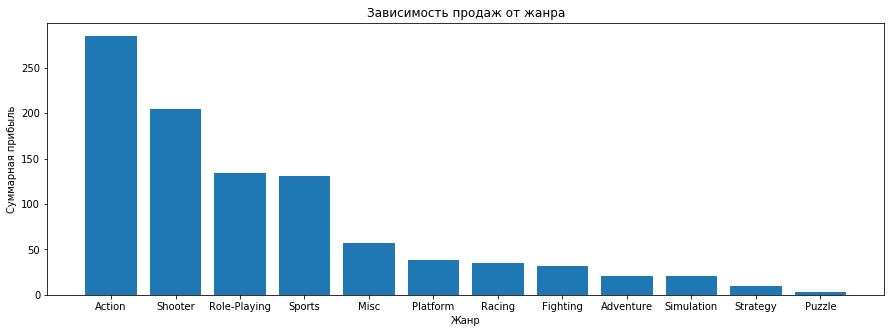

In [31]:
df_genre = df.pivot_table(index='genre',values='sum_sales',aggfunc='sum').sort_values(by='sum_sales',ascending=False)
genres = df_genre.index
sales_per_genre = np.squeeze(df_genre.values)

plt.rcParams['figure.figsize'] = (15,5) 

plt.bar(genres,sales_per_genre)
plt.title('Зависимость продаж от жанра')
plt.xlabel('Жанр')
plt.ylabel('Суммарная прибыль')

plt.show()

In [32]:
df['genre'].value_counts()

Action          769
Role-Playing    292
Adventure       245
Sports          214
Shooter         187
Misc            156
Racing           85
Fighting         80
Platform         74
Simulation       62
Strategy         56
Puzzle           17
Name: genre, dtype: int64

Было построено два графика: по средней прибыли и по суммарной прибыли. Сделано это для того, чтобы показать, что жанр "Action" превосходит все другие благодаря своей популярности и количеству игр. Однако по средней выручке он сильно отстает и тут явныл лидером является жанр "Shooter".

Вывод по данному разделу:

Вначале мы построили гистограмму, показывающую количество выпускаемых игр с 1980 по 20116 гг. Также нарисовали диаграмму размаха по годам. Все это - для определения предварительной границы отсеивания данных. 

Далее мы нашли топ-10 платформ по суммарным продажам и построили гистограммы, описывающие количество выпускаемых игр на каждой платформе по годам. Это помогло нам определить характерный срок жизни платформы, равный примерно 10 годам.

Изначально, целью нашего анализа - определить то, какие игры и на каких платформах надо выпускать к 2017 году, чтобы достичь максимальной прибыли. После определения характерного срока жизни платформы, мы снова произвели срез данных, необходимый для проведения нашего анализа. Далее мы снова определили топ-5 платформ для нового среза, в который попали, некоторые платформы, ранее не попавшие в топ-10. Это XOne и 3DS. Для первой это связано с тем, что данная платформа еще молода и не успела выбиться в лидеры по суммарным продажам, а вторая - самая популярная платформа в Японии, где компьютерные игры не так популярны, как в других регионах, отсюда и отсутствие в изначальном топ-10 (она также далеко не ушла от своего пика).

Позже было расчитано среднее значение продаж по каждой платформе из топ-5; посчитаны корреляции для них между отзывами пользователей и критиков относительно суммарных продаж. Выяснили, что чаще именно отзывы критиков влияют на прибыльность игры. Исключение составляет 3DS, у которой и отзывы пользователей оказывают влияние на продаваемость. Видимо в Японии пользователи больше прислушиваются к другим пользователям.

В конце мы определили самый популярный жанр - "Action" и самый прибыльный в среднем - "Shooter". В топ-5 также входит еще "Sports", "Role-Playing" и "Racing".

## Шаг 4. Составьте портрет пользователя каждого региона

Для пользователя каждого региона определим самые популярные платформы.

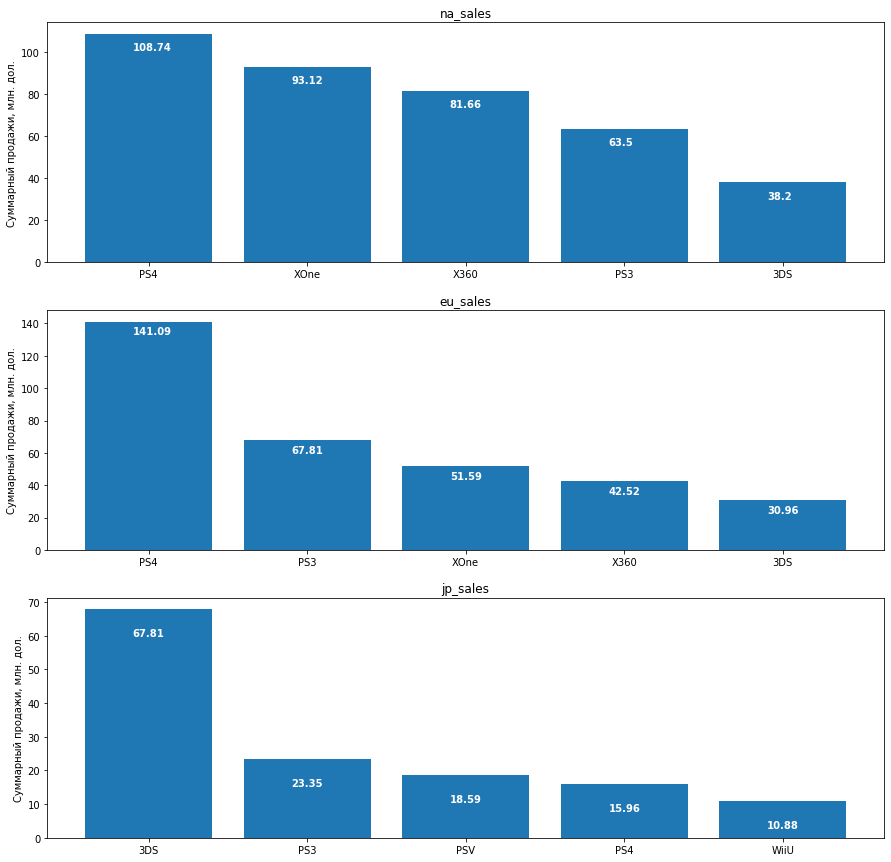

In [33]:
regions = ['na_sales','eu_sales','jp_sales']

fig,ax = plt.subplots(3,1)

for i in range(len(regions)):
    region = regions[i]
    df_region = df.pivot_table(index='platform',values=region,aggfunc='sum').sort_values(by=region,ascending=False).head()
    sales = np.round(np.squeeze(df_region.values),2)
    ax[i].bar(df_region.index,sales)
    for j in range(len(sales)):
        ax[i].text(j-.1,sales[j]-8,str(sales[j]),color='white',fontweight='bold')
    
    ax[i].set_title(region)
    ax[i].set_ylabel('Суммарный продажи, млн. дол.')

fig.set_size_inches(15,15)
    
plt.show()

1. Для Европы явным лидером среди платформ по суммарным продажам - PS4. На втором месте PS3, а на третьем - XOne.
2. У Японии в прибыльности отличается платформа 3DS. После нее скромно идут PS3 и PSV. PS4 аж на 4 месте.
3. В США лидером, как и в Европе, является PS4, но уже не так уверенно. Данной платформе хорошую конкуренцию представляет XOne. Далее идут X360 и PS3.

В Европе продажи на платформе PS4 превышают те, что в США на 33%, а в Европе, по сравнению с 3DS, почти на 50%. Первый очевидный вывод - в Японии люди меньше играют в компьютерные игры.

По лидеру Европа может и лидирует, однако в остальных платформах США явно превосходит по продажам Европу. Так, XOne опережает на 55%, X360 на 52%, а PS3 примерно равны по продажам с небольшим преисуществом в 7% для Европы.

Предварительный вывод: игроки, живущие в Европе, определились с любимой платформой - это PS4 и PS3. А пользователи в США более разнообразны, здесь также большую популярность имеет XOne и X360. 

Заметка: Если построить сводную таблицу не по сумме, а по среднему, то графики немного изменятся для США. X360 станет на первое место, а XOne, на второе. PS4 вообще уйдетна 4 место. Думаю это связано с тем, что у X360 значений на пике больше по количеству, а XOne опережает PS4 примерно по той же причине. Вероятно к 2017 году XOne уже будет близко к началу снижения, а PS4 только только подойдет к пику, соответственно PS4 чуть более актуальна, даже не учитывая явное опережение в популярности в Европе. 

Теперь исследуем жанры по регионам.

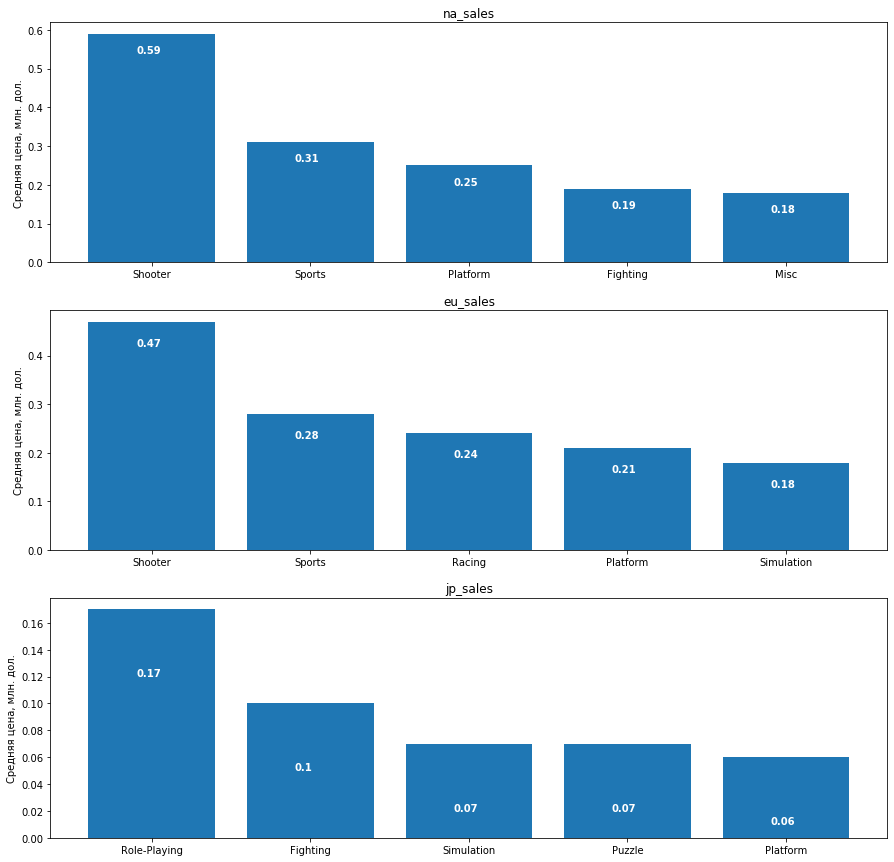

In [34]:
regions = ['na_sales','eu_sales','jp_sales']

fig,ax = plt.subplots(3,1)

for i in range(len(regions)):
    region = regions[i]
    df_region = df.pivot_table(index='genre',values=region).sort_values(by=region,ascending=False).head()
    sales = np.round(np.squeeze(df_region.values),2)
    ax[i].bar(df_region.index,sales)
    for j in range(len(sales)):
        ax[i].text(j-.1,sales[j]-.05,str(sales[j]),color='white',fontweight='bold')
    
    ax[i].set_title(region)
    ax[i].set_ylabel('Средняя цена, млн. дол.')

fig.set_size_inches(15,15)
    
plt.show()

По первым двух жанрам по популярности в США и Европе полное совпадение с той лишь разницей, что шутеры в среднем получают больше прибыли в США. Начиная с третьего места жанры отличаются.

В Японии же совсем другая картина. Конечно, людей здесь играет меньше, отсюда и средняя прибыль по каждому жанру меньше, чем в Европе и США. Однако, Самым популярным жанром является "Role-Playing". На втором месте "Fighting", который также присутствует в топ-5 в США, есть "Simulation", который также присутствует в Европе и "Platform", который в топ-5 всех регионов. В этой стране также популярны головоломки.

Теперь определим то, как влияет рейтинг ESRB на продажи в каждом регионе.

In [35]:
df.pivot_table(index='rating',values='na_sales')

,na_sales
rating,
E,0.261755
E10+,0.215238
M,0.444328
T,0.149520


In [36]:
df.pivot_table(index='rating',values='eu_sales')

,eu_sales
rating,
E,0.276026
E10+,0.169405
M,0.391935
T,0.125976


In [37]:
df.pivot_table(index='rating',values='jp_sales')

,jp_sales
rating,
E,0.050132
E10+,0.023373
M,0.037930
T,0.061832


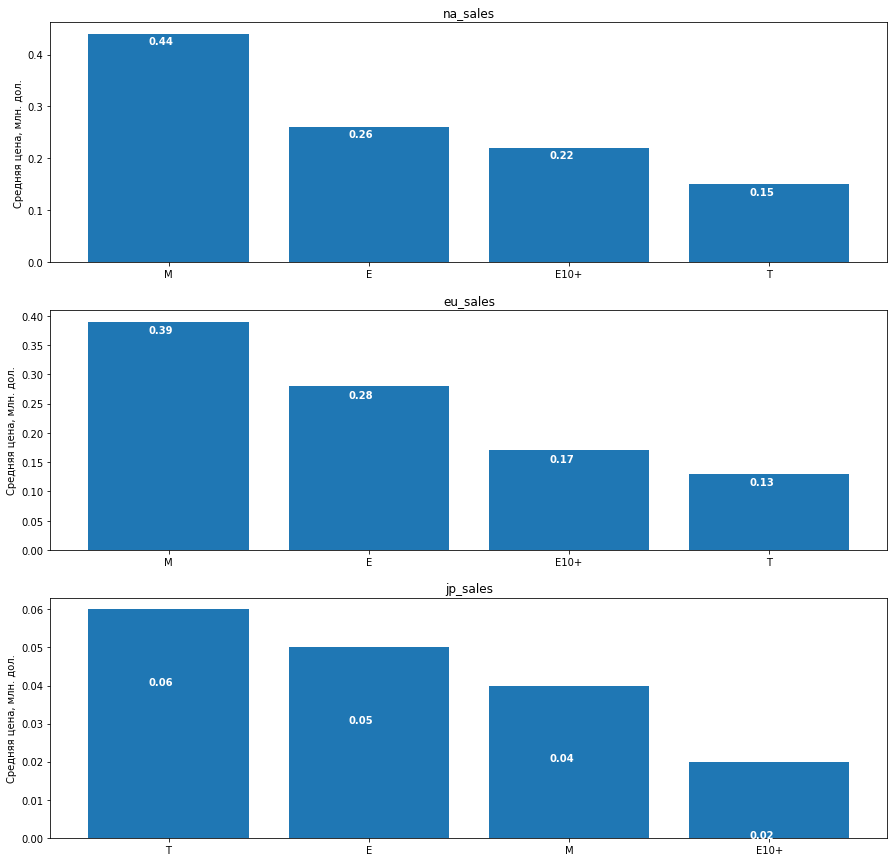

In [38]:
regions = ['na_sales','eu_sales','jp_sales']

fig,ax = plt.subplots(3,1)

for i in range(len(regions)):
    region = regions[i]
    df_region = df.pivot_table(index='rating',values=region).sort_values(by=region,ascending=False).head()
    sales = np.round(np.squeeze(df_region.values),2)
    ax[i].bar(df_region.index,sales)
    for j in range(len(sales)):
        ax[i].text(j-.1,sales[j]-.02,str(sales[j]),color='white',fontweight='bold')
    
    ax[i].set_title(region)
    ax[i].set_ylabel('Средняя цена, млн. дол.')

fig.set_size_inches(15,15)
    
plt.show()

Самым популярным ретингом для США и Европы является M (Mature) для игроков старше 17 лет. Дальше идут E (Everyone), E10+ (старше 10 лет) и T (Teens) - старше 13 лет.

В Японии самыйй популярный рейтинг - T, дальше идут E, а M фж на 3 месте. Кажется тут все строго.

Общий вывод - да, рейтинг влияет на продажи. Выгоднее создавать игры для возрастного ограничения 17+.

## Шаг 5. Проверьте гипотезы

Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;

$H_0$: средние рейтинги платформ равны.

$H_1$: средние рейтинги не равны.

In [55]:
XOne_ratings = df.query('platform == "XOne" and user_score != "tbd"')['user_score'].reset_index(drop=True)
XOne_ratings = pd.to_numeric(XOne_ratings)
XOne_ratings_mean = round(XOne_ratings.mean(),3)

PC_ratings = df.query('platform == "PC" and user_score != "tbd"')['user_score'].reset_index(drop=True)
PC_ratings = pd.to_numeric(PC_ratings)
PC_ratings_mean = round(PC_ratings.mean(),3)

print('Средний рейтинг XOne: ' + str(XOne_ratings_mean))
print('Средний рейтинг PC: ' + str(PC_ratings_mean))


alpha = .05

results = st.ttest_ind(XOne_ratings[XOne_ratings.notnull()].values,PC_ratings[PC_ratings.notnull()].values)

print('p-value = ' + str(results.pvalue))

if(results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем')


Средний рейтинг XOne: 6.521
Средний рейтинг PC: 6.28
p-value = 0.15503167687396294
Не отвергаем


Полученное значение говорит о том, что с вероятностью 15.5% разница в рейтинге получается случайной. Это выше заданного уровня критической значимости, следовательно гипотезу не опровергли. Следовательно, рейтинги скорее всего равны.

Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

$H_0$: средние рейтинги равны.

$H_1$: средние рейтинги разные.

In [57]:
#Извлечем все необходимые данные для проверки
Action_ratings = df.query('genre == "Action" and user_score != "tbd"')['user_score'].reset_index(drop=True)
Action_ratings = pd.to_numeric(Action_ratings)
Action_ratings_mean = round(Action_ratings.mean(),3)

Sport_ratings = df.query('genre == "Sports" and user_score != "tbd"')['user_score'].reset_index(drop=True)
Sport_ratings = pd.to_numeric(Sport_ratings)
Sport_ratings_mean = round(Sport_ratings.mean(),3)

print('Средний рейтинг Action: ' + str(Action_ratings_mean))
print('Средний рейтинг Sport: ' + str(Sport_ratings_mean))

alpha = .05

results = st.ttest_ind(Action_ratings[Action_ratings.notnull()].values,Sport_ratings[Sport_ratings.notnull()].values)

print('p-value = ' + str(results.pvalue))

if(results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем')


Средний рейтинг Action: 6.838
Средний рейтинг Sport: 5.238
p-value = 8.11729623919141e-28
Отвергаем нулевую гипотезу


Если бы pvalue было бы большим, то мы не опровергли бы нашу нулевую гипотезу и считали бы, что средние рейтинги не разные, то есть равны. Но мы ее отвергли, а значит рейтинги данных жанров разные. Вероятность получить ту разность в рейтингах, которую мы получили, случайно - маловероятно. Вывод - рейтинги данных жанров скорее всего разные.

## Шаг 6. Напишите общий вывод

К 2017 году самыми популярными платформами будут: PS4, XOne, PS3, 3DS и X360. Причем последние три уже прошли свой пик и продажи по ним не будут такими прибыльными, как пару лет назад. Самыми главными платформами, на которые стоит ориентироваться к 2017 году - PS4 и XOne. Это явные лидеры для Европы и США. В Японии популярность игр значительно ниже, чем в других регионах и популярнее всего здесь платформа 3DS. 

Самыми прибыльными жанрами для США и Европы являются "Shooter" и "Sports", а самыми популярными - "Action". В Японии снова картина отличается: самым популярным жанром является "Role-Playing". В топ-5 для это страны также входят те жанры, которые присутствуют и в других странах, однако, в этой стране также любят головоломки.

Было выяснено, что пользовательские рейтинги не оказывают особого влияния на продажи (в отличии от Японии), однако для США и Европы характерна достаточно сильная положительная корреляция с отзывами критиков на продажи.

Также узнали, что рейтинг ESRB тоже влияет на продажи. M (Mature) - игры для 17+ наиболее популярны в Европе и США. Вообще весь топ-5 для этих двух регионов идентичен. Для Японии самым популярным жанром является T (Teens) 13+. Наверное, в такой строгой стране игры не так популярны и играют в них только дети, в принципе похоже на правду.

Проведя проверку статистических гипотез выявили, что средние пользовательские рейтинги игр на платформах PS4 и XOne скорее всего одинаковы. А средние пользовательские рейтинги жанров "Action" и "Sports" вероятнее всего разные.